# Get a single face from a video

In [1]:
#default_exp nb_01b

In [2]:
#export
from fastai.vision import *
from kgl_deepfake.nb_00 import *
from kgl_deepfake.nb_01 import *
from IPython.display import HTML
import cv2
import pandas as pd
from facenet_pytorch import MTCNN

In [3]:
torch.multiprocessing.set_start_method('spawn')

### Data

In [4]:
SOURCE = Path('../data/train_sample_videos/')

In [5]:
f = get_files(SOURCE, extensions=['.json'])[0]
annots = pd.read_json(f).T
annots.reset_index(inplace=True)
annots.rename({'index':'fname'}, axis=1, inplace=True)
annots.head()

,fname,label,split,original
0,aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4
1,aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4
2,abarnvbtwb.mp4,REAL,train,None
3,abofeumbvv.mp4,FAKE,train,atvmxvwyns.mp4
4,abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4


In [6]:
fn = SOURCE/annots.fname[0]
fn

PosixPath('../data/train_sample_videos/aagfhgtpmv.mp4')

### Get the first detected face from a video

In [7]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
detector = MTCNN(device=device, post_process=False, select_largest=False)

In [8]:
#export
def get_first_face(detector, fn, resize=.5, equalize=False):
    '''
    Returns the first detected face from a video
    '''
    assert Path(fn).exists()
    v_cap = cv2.VideoCapture(str(fn))
    v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))
    iframe, face = None, None
    for i in range(v_len):
        _ = v_cap.grab()
        success, frame = v_cap.retrieve()
        if not success: continue
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2YCrCb)
        if equalize:
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
            frame[:,:,0] = clahe.apply(frame[:,:,0])
        frame = cv2.cvtColor(frame, cv2.COLOR_YCrCb2RGB)
        frame = PIL.Image.fromarray(frame)
        if resize is not None: frame = frame.resize([int(d * resize) for d in frame.size])
        face = detector(frame)
        if face is not None:
            iframe = i
            break
    v_cap.release()
    return iframe, face

### Videos in which not a single face is detected by MTCNN

Using `equalize = True` (see 02_fix_luminosity.ipynb), there are no videos from *train_sample_videos* in which no face cannot be detectd.

In [9]:
#export
def get_has_face(fnames, detector):
    if isinstance(fnames, (str, Path)): fnames = [fnames]
    res = []
    for i in progress_bar(range(len(fnames))):
        iframe, face = get_first_face(detector, fnames[i], equalize=True)
        res.append(True if iframe is not None else False)
    return res

In [10]:
fnames = [SOURCE/o for o in annots.fname]
hasface = get_has_face(fnames, detector)

In [11]:
len(hasface), len([o for o in hasface if o == False])

(400, 0)

In [12]:
annots_noface = annots[~np.array(hasface)]

In [13]:
annots_noface.shape

(0, 4)

In [14]:
fnames_noface = [SOURCE/o for o in annots_noface.fname]
labels = [f'{o.fname} {o.label}' for i, o in annots_noface.iterrows()]

In [15]:
HTML(html_vids(fnames_noface, titles=labels))

Save annotations for videos with no detected faces for further investigation.

In [16]:
annots_noface.to_csv('annots_noface.csv', index=False)

In [17]:
annots_noface = pd.read_csv('annots_noface.csv')

### `ItemList` that returns the first face from a video

In [18]:
#export
class VideoFaceList(ImageList):
    def __init__(self, *args, **kwargs):
        device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
        detector = MTCNN(device=device, post_process=False, select_largest=False, margin=0)
        self.detector = detector
        self.resize = .5
        self.equalize = True
        super().__init__(*args, **kwargs)
    
    def get_face(self, fn:Path):
        iframe, face = get_first_face(self.detector, fn, self.resize, self.equalize)
        if iframe is None or face is None: raise Exception(f'No faces detected in {fn}')
        return iframe, face
    
    def open(self, fn:Path):
        iframe, face = self.get_face(fn)
        return Image(face / 255)

In [20]:
src = VideoFaceList.from_df(df=annots, path=SOURCE, cols='fname').split_by_rand_pct()

In [21]:
src.train.detector.select_largest, src.valid.detector.select_largest

(False, False)

In [22]:
src.train.equalize, src.valid.equalize

(True, True)

In [23]:
%%time
src

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 34.1 µs


ItemLists;

Train: VideoFaceList (320 items)
Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160)
Path: ../data/train_sample_videos;

Valid: VideoFaceList (80 items)
Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160)
Path: ../data/train_sample_videos;

Test: None

In [24]:
%%time
sz, bs = 160, 32
data = (src.label_from_df('label').transform(get_transforms(), size=sz)
        .databunch(bs=bs, num_workers=0).normalize(imagenet_stats))

CPU times: user 20.3 s, sys: 2.9 s, total: 23.2 s
Wall time: 13.9 s


In [25]:
%%time
xb, yb = next(iter(data.train_dl))

CPU times: user 19 s, sys: 2.57 s, total: 21.6 s
Wall time: 12.9 s


In [26]:
xb.shape, yb.shape

(torch.Size([32, 3, 160, 160]), torch.Size([32]))

In [27]:
yb

tensor([0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

In [28]:
%%time 
xb, yb = next(iter(data.valid_dl))

CPU times: user 18.8 s, sys: 2.53 s, total: 21.3 s
Wall time: 12.4 s


In [29]:
xb.shape, yb.shape

(torch.Size([32, 3, 160, 160]), torch.Size([32]))

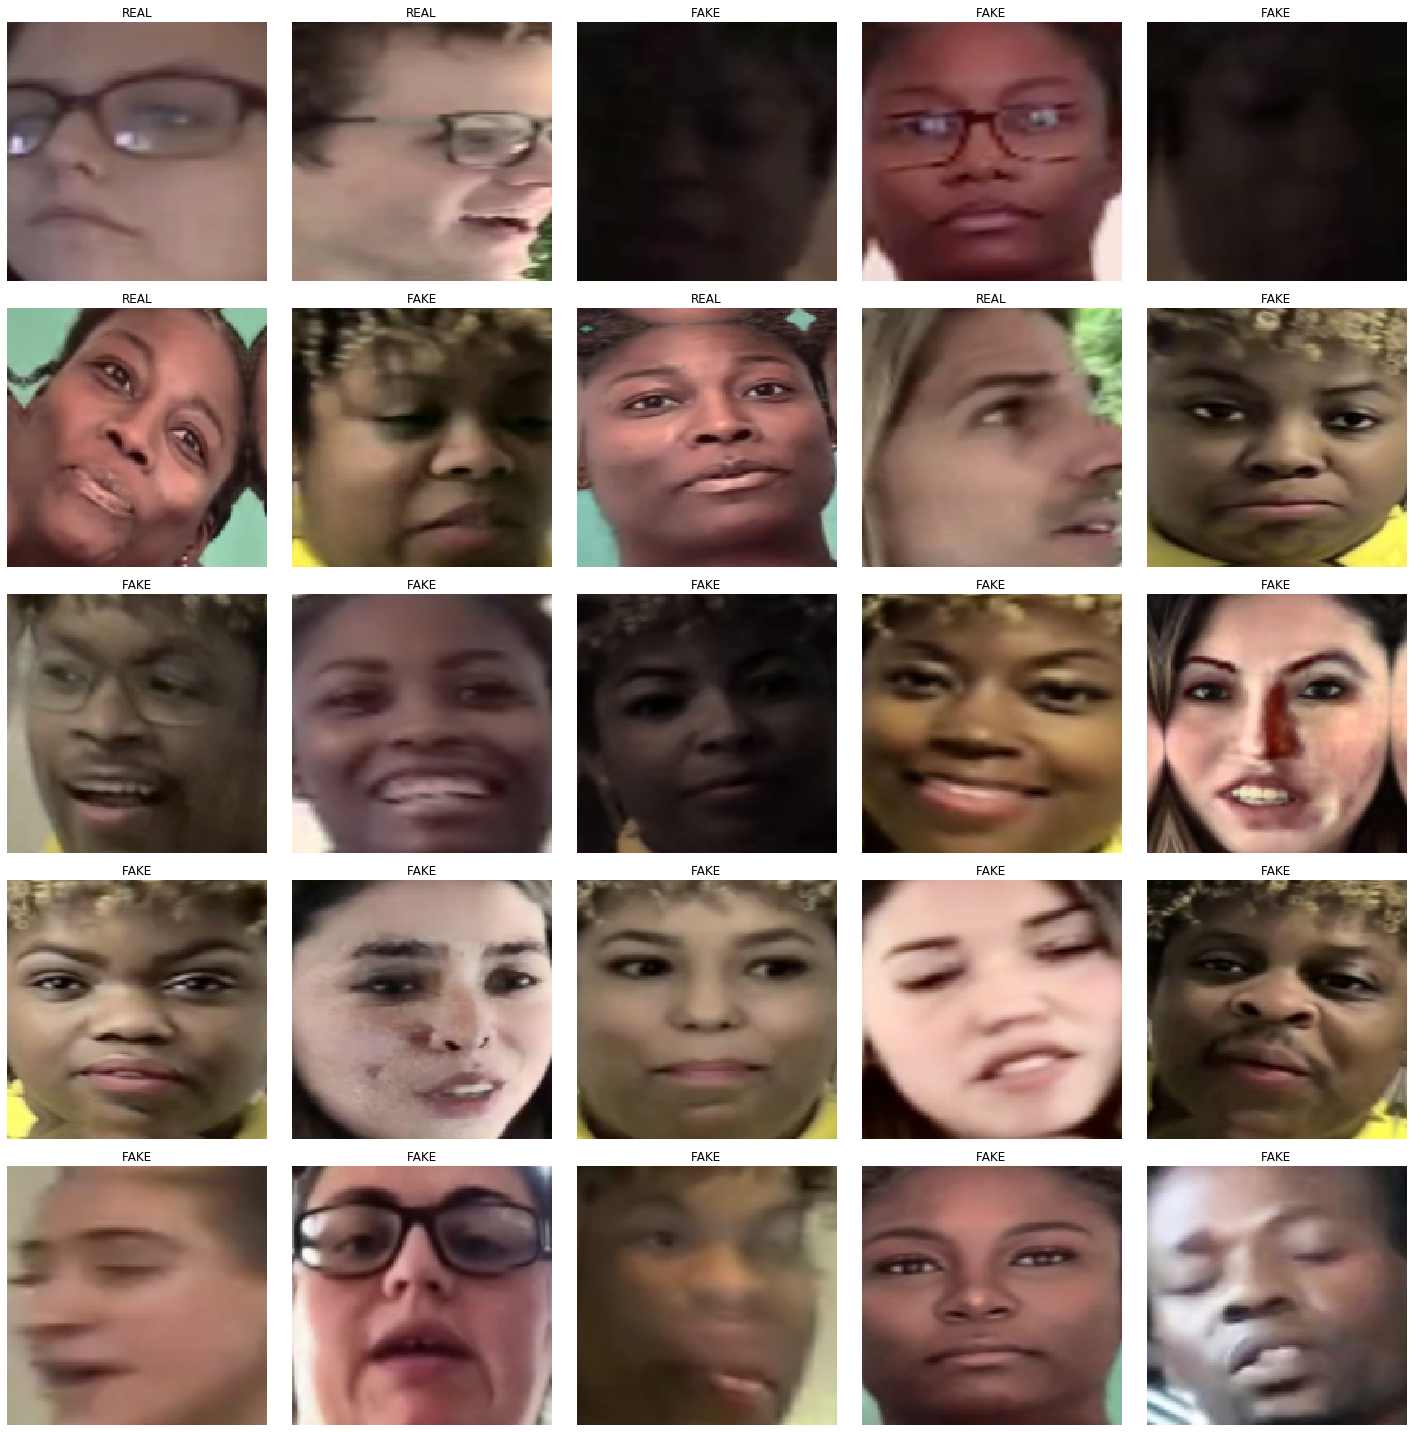

In [32]:
data.show_batch(ds_type=DatasetType.Train)

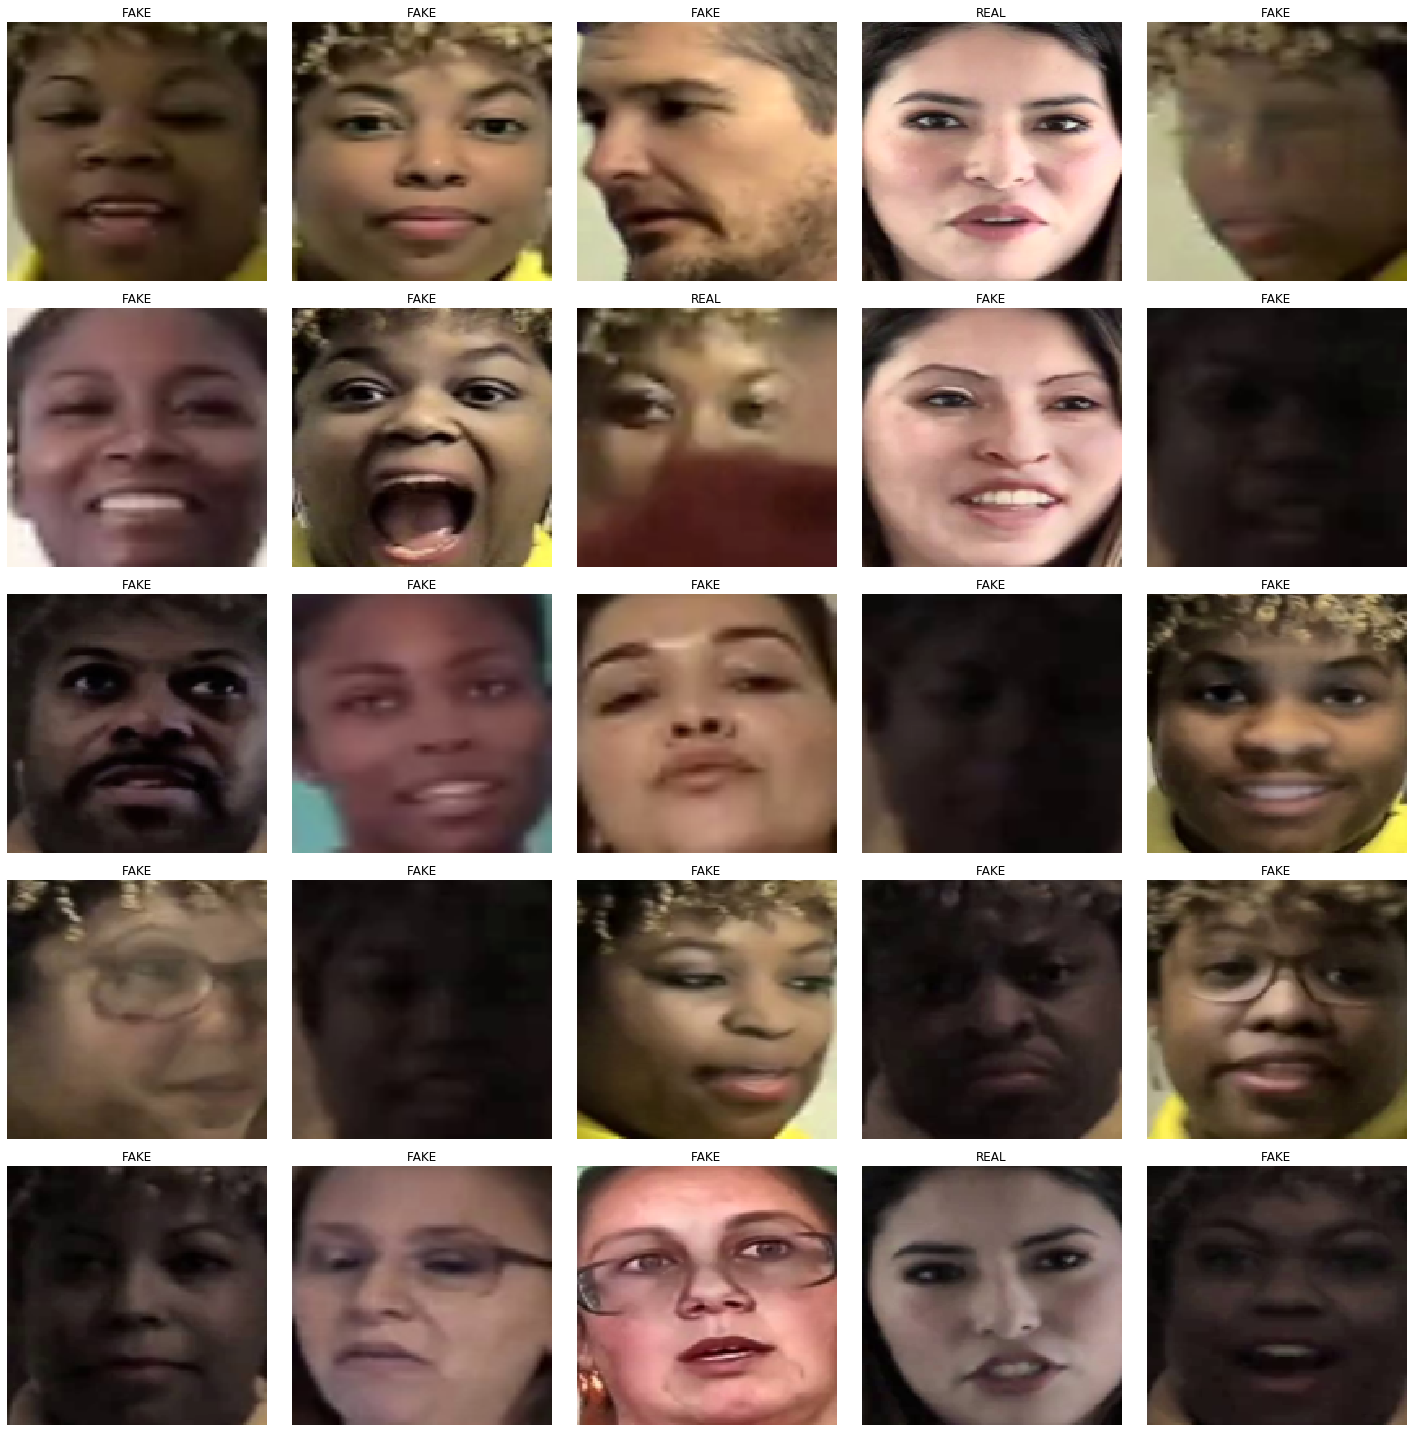

In [33]:
data.show_batch(ds_type=DatasetType.Valid)

# -fin

In [34]:
from nbdev.export import *
notebook2script()

Converted 00_lookatdata.ipynb.
This cell doesn't have an export destination and was ignored:
e
This cell doesn't have an export destination and was ignored:
e
This cell doesn't have an export destination and was ignored:
e
This cell doesn't have an export destination and was ignored:
e
Converted 01_face_recog.ipynb.
Converted 01a_face_extraction.ipynb.
Converted 01b_get_one_face.ipynb.
This cell doesn't have an export destination and was ignored:
e
Converted 01c_noface_videos.ipynb.
Converted 01d_most_likely_face.ipynb.
Converted 01e_margin.ipynb.
This cell doesn't have an export destination and was ignored:
e
Converted 02_fix_luminosity-Copy1.ipynb.
Converted 02_fix_luminosity.ipynb.
Converted 02a_create_faceimage_dataset.ipynb.
Converted 02bis_Create_Dataset-Copy1.ipynb.
Converted 02bis_Create_Dataset.ipynb.
Converted 03_mesonet.ipynb.
Converted 04_Baseline_Classification-Copy1.ipynb.
Converted 04_Baseline_Classification.ipynb.
Converted 04_Classification-Copy1.ipynb.
Converted 04_Cl